In [109]:
import re
from d2l import torch as d2l

def read_timemachine():
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    lines = [re.sub('[^A-Za-z,.]+', ' ', line).strip().lower() for line in lines]
    return lines

tokens = d2l.tokenize( read_timemachine(), 'word' )
vocab = d2l.Vocab(tokens)
tokens = [token for line in tokens for token in line]
corpus = [vocab[token] for token in tokens]

print(len(vocab.token_to_idx), len(corpus), tokens[:10], corpus[:10], vocab.token_freqs[:10], sep='\n')

6065
32787
['the', 'time', 'machine,', 'by', 'h.', 'g.', 'wells', 'i', 'the', 'time']
[1, 18, 192, 38, 2438, 2439, 783, 2, 1, 18]
[('the', 2261), ('i', 1258), ('and', 1219), ('of', 1154), ('a', 815), ('to', 694), ('was', 540), ('in', 539), ('my', 440), ('that', 422)]


In [111]:
corpus_bi = [(x, y) for x, y in zip(tokens[:-1], tokens[1:])]
vocab_bi = d2l.Vocab(corpus_bi)

vocab_bi.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 111),
 (('and', 'the'), 109),
 (('the', 'time'), 97),
 (('it', 'was'), 93),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [112]:
corpus_tri = [(x, y, z) for x, y, z in zip(tokens[:-2], tokens[1:], tokens[2:])]
corpus_tri = d2l.Vocab(corpus_tri)

corpus_tri.token_freqs[:10]

[(('the', 'time', 'traveller'), 40),
 (('it', 'seemed', 'to'), 16),
 (('i', 'did', 'not'), 14),
 (('it', 'was', 'a'), 14),
 (('the', 'time', 'machine'), 13),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13),
 (('said', 'the', 'time'), 12),
 (('out', 'of', 'the'), 12),
 (('a', 'kind', 'of'), 11)]

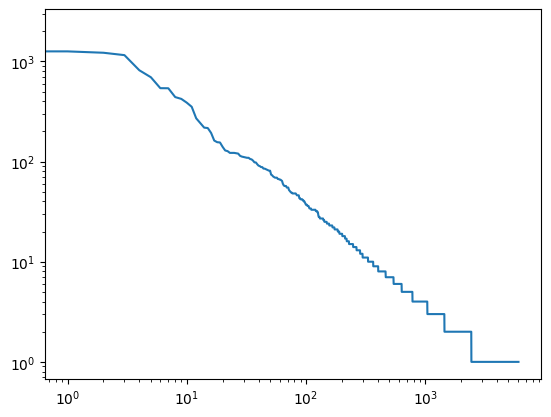

In [100]:
import matplotlib.pyplot as plt
freq = [y for x, y in vocab.token_freqs]

plt.xscale('log')
plt.yscale('log')
plt.plot(freq)

Text(0.5, 1.0, 'log exp(x)')

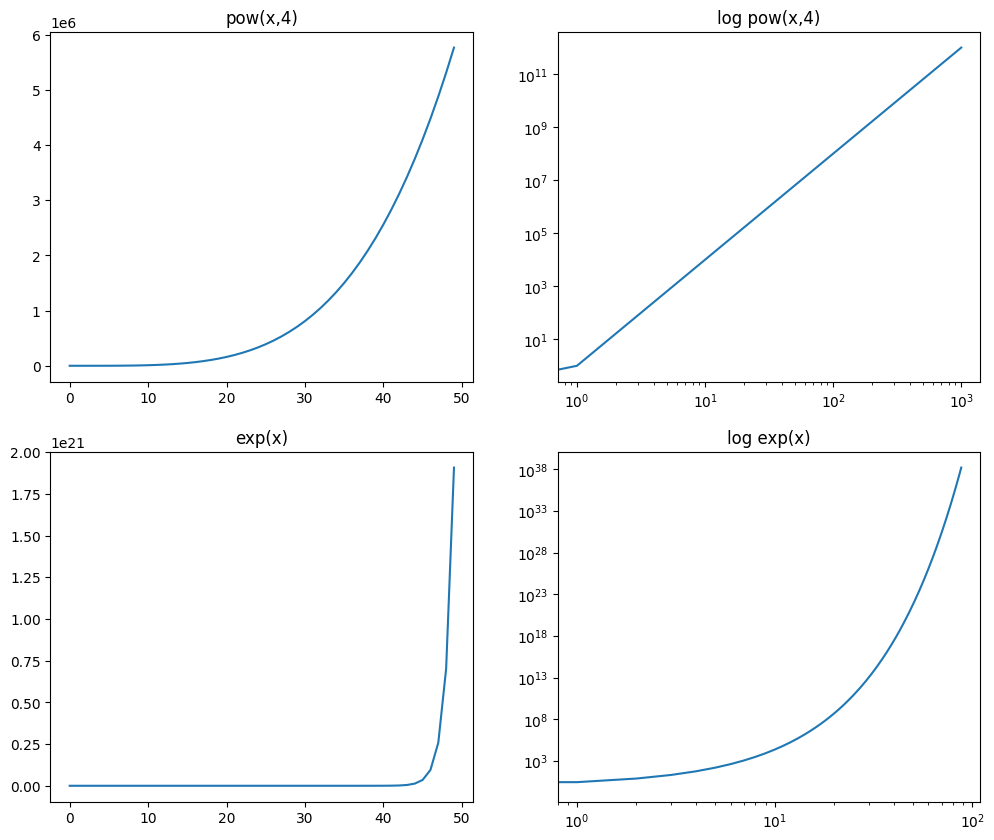

In [86]:
import torch
import matplotlib.pyplot as plt
x = torch.arange(1000)
y1 = torch.pow(x, 4) # x^4，幂增长
y2 = torch.exp(x)    # e^x，指数增长

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 10)
axes[0][0].plot(x[:50], y1[:50])
axes[0][0].set_title('pow(x,4)')

axes[0][1].set_xscale('log')
axes[0][1].set_yscale('log')
axes[0][1].plot(x, y1)      # 幂增长在log尺度下是线性的
axes[0][1].set_title('log pow(x,4)')

axes[1][0].plot(x[:50], y2[:50])
axes[1][0].set_title('exp(x)')

axes[1][1].set_xscale('log')
axes[1][1].set_yscale('log')
axes[1][1].plot(x, y2)      # 指数增长在log尺度下是幂增长的形态
axes[1][1].set_title('log exp(x)')

In [125]:
import random
def seq_data_iter_random(corpus, batch_size, num_steps):
    k = random.randint(0, num_steps-1)
    print(k)
    bs = ( len(corpus) - k - 1 ) // num_steps
    indices = [k + _bs * num_steps for _bs in range(bs)]
    random.shuffle(indices)

    for idx in range(0, len(indices), batch_size):
        yield torch.tensor([ corpus[ indices[idx+i]: indices[idx+i]+num_steps ] for i in range(batch_size)] ), \
              torch.tensor([ corpus[ indices[idx+i]+1: indices[idx+i]+num_steps+1 ] for i in range(batch_size)])

my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

1
X:  tensor([[ 1,  2,  3,  4,  5],
        [16, 17, 18, 19, 20]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [17, 18, 19, 20, 21]])
X:  tensor([[11, 12, 13, 14, 15],
        [21, 22, 23, 24, 25]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [22, 23, 24, 25, 26]])
X:  tensor([[26, 27, 28, 29, 30],
        [ 6,  7,  8,  9, 10]]) 
Y: tensor([[27, 28, 29, 30, 31],
        [ 7,  8,  9, 10, 11]])


In [129]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

my_seq = list(range(35))
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 1,  2,  3,  4,  5],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]])
X:  tensor([[ 6,  7,  8,  9, 10],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]])
X:  tensor([[11, 12, 13, 14, 15],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]])
